# Text Classification Project: Analyzing Emotional Text Data

## Introduction

In this project, we aim to perform text classification on a dataset containing emotional text data. Our objective is to classify text samples into different emotional categories such as sadness, joy, love, anger, fear, and surprise. This project involves extensive preprocessing of the text data, balancing the class distribution, and training multiple classification models to predict the emotion labels.

## Project Overview

### Objective: 
Perform text classification on emotional text data.

### Dataset: 
Labeled text samples categorized into different emotions.

### Approach: 
Preprocessing, balancing class distribution, model training, and evaluation.

# Step 1: Reading and Understanding the Dataset

1.Importing Libraries: We'll begin by importing the necessary libraries for data manipulation, visualization, and machine learning.

In [4]:
import pandas as pd

2.Reading the Dataset: Load the dataset into a Pandas DataFrame and display the first few rows to understand its structure.

In [5]:
# Read the dataset
df = pd.read_csv("Emotions_training.csv")

# Display the first few rows of the DataFrame
print(df.head())

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3


# Step 2: Exploratory Data Analysis (EDA)

1.Understanding the Data: We'll explore the basic properties of the dataset such as the number of rows and columns, data types, and any missing values.

In [6]:
# Display the shape of the dataset (number of rows and columns)
print("Shape of the dataset:", df.shape)

# Check the data types of each column
print("\nData types of each column:")
print(df.dtypes)

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

Shape of the dataset: (16000, 2)

Data types of each column:
text     object
label     int64
dtype: object

Missing values:
text     0
label    0
dtype: int64


2.Exploring the Target Variable: We'll analyze the distribution of the target variable (label) to understand class imbalance and the distribution of emotions.

In [8]:
# Display the distribution of the target variable (label)
print("\nDistribution of the target variable (label):")
print(df['label'].value_counts())


Distribution of the target variable (label):
label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64


3.Visualizing Data: We can create visualizations to better understand the data, such as histograms for numeric features and bar plots for categorical features.

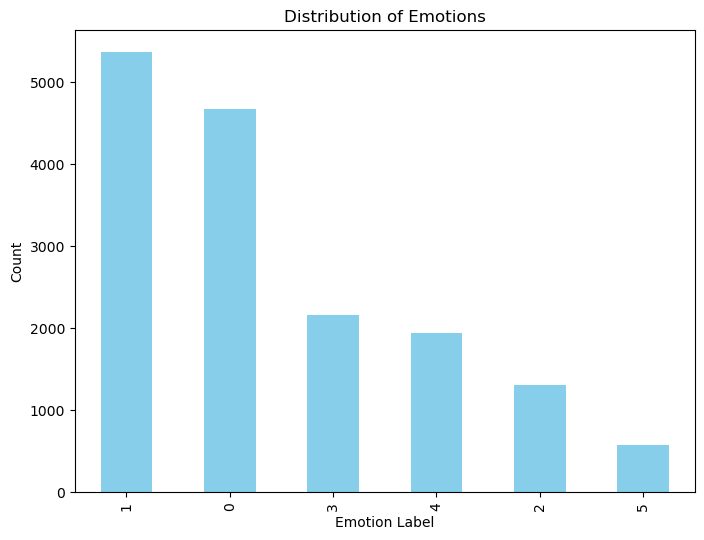

In [9]:
import matplotlib.pyplot as plt

# Visualize the distribution of the target variable
plt.figure(figsize=(8, 6))
df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Emotions')
plt.xlabel('Emotion Label')
plt.ylabel('Count')
plt.show()

# Step 3: Data Preprocessing

Data preprocessing is essential to prepare the text data for modeling. This involves several tasks such as:

1.Text Cleaning: Removing any unwanted characters, symbols, or special characters that do not contribute to the meaning of the text.

2.Tokenization: Breaking down the text into individual words or tokens.

3.Removing Stopwords: Eliminating common words such as "is", "the", "and", which do not carry significant meaning.

4.Stemming or Lemmatization: Reducing words to their root form to normalize the text.

5.Vectorization: Converting the text into numerical features that can be used by machine learning algorithms.

#### Let's start with the first task:

1. Text CleaningText cleaning involves removing unwanted characters, symbols, or special characters from the text data.

In [40]:
import re

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the clean_text function to the 'text' column
df['clean_text'] = df['text'].apply(clean_text)


Moving on to the next preprocessing task:

2. TokenizationTokenization involves splitting the text into individual words or tokens. This step is essential for further analysis and feature extraction.

In [11]:
import nltk
from nltk.tokenize import word_tokenize

# Download necessary resources for tokenization
nltk.download('punkt')

# Tokenize the text in the 'clean_text' column
df['tokens'] = df['clean_text'].apply(word_tokenize)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sumit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


3. Removing StopwordsStopwords are common words that often do not carry significant meaning in text analysis and can be safely removed to improve processing efficiency and model performance.

In [12]:
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Get English stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from tokenized text
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

# Remove stopwords from the 'tokens' column
df['tokens'] = df['tokens'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sumit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


4. StemmingStemming is the process of reducing words to their root or base form. It helps in reducing inflected words to their word stem and often involves removing suffixes or prefixes. This step can help in further reducing the dimensionality of the data and improving the efficiency of downstream tasks.

In [13]:
from nltk.stem import PorterStemmer

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

# Function to apply stemming to tokens
def apply_stemming(tokens):
    return [stemmer.stem(word) for word in tokens]

# Apply stemming to the 'tokens' column
df['tokens'] = df['tokens'].apply(apply_stemming)


5. LemmatizationLemmatization is similar to stemming but aims to return the base or dictionary form of a word, known as the lemma. Unlike stemming, lemmatization considers the context and meaning of a word, which can result in more accurate transformations.

In [14]:
from nltk.stem import WordNetLemmatizer

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to apply lemmatization to tokens
def apply_lemmatization(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

# Apply lemmatization to the 'tokens' column
df['tokens'] = df['tokens'].apply(apply_lemmatization)


6. Convert Tokens Back to TextAfter preprocessing the text data, it's common to convert the tokenized words back into a single string of text for further analysis or modeling.

In [15]:
# Function to convert tokens back to text
def tokens_to_text(tokens):
    return ' '.join(tokens)

# Apply the function to the 'tokens' column to convert tokens back to text
df['preprocessed_text'] = df['tokens'].apply(tokens_to_text)

# Display the DataFrame with the preprocessed text
print(df[['text', 'preprocessed_text']].head())


                                                text  \
0                            i didnt feel humiliated   
1  i can go from feeling so hopeless to so damned...   
2   im grabbing a minute to post i feel greedy wrong   
3  i am ever feeling nostalgic about the fireplac...   
4                               i am feeling grouchy   

                                   preprocessed_text  
0                                  didnt feel humili  
1  go feel hopeless damn hope around someon care ...  
2               im grab minut post feel greedi wrong  
3     ever feel nostalg fireplac know still properti  
4                                       feel grouchi  


7. Split the Dataset into Training and Testing SetsBefore training a machine learning model, it's essential to split the dataset into training and testing sets. The training set is used to train the model, while the testing set is used to evaluate its performance on unseen data.

In [16]:
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and labels (y)
X = df['preprocessed_text']
y = df['label']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (12800,)
Testing set shape: (3200,)


8. Text VectorizationIn order to train a machine learning model on text data, we need to convert the text into numerical features that the model can understand. One common approach is to use a technique called TF-IDF (Term Frequency-Inverse Document Frequency) vectorization.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test)


## 2.Model Training and Evaluation:

9. Training the Model Now that we have preprocessed our text data and converted it into numerical features using TF-IDF vectorization, we can train our classification model. Let's start with the Support Vector Machine (SVM) classifier.

In [18]:
from sklearn.svm import SVC

# Initialize the SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)  # You can choose different kernels and parameters

# Train the SVM classifier on the TF-IDF transformed training data
svm_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the testing data
y_pred_svm = svm_classifier.predict(X_test_tfidf)


This variable should contain the labels corresponding to each emotion class. Let's define it and then visualize the confusion matrix again.

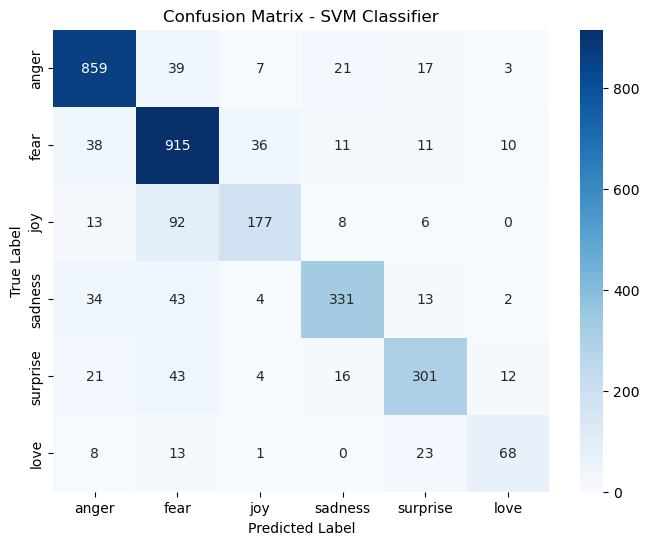

In [20]:
emotion_labels = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'sadness', 4: 'surprise', 5: 'love'}

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.title('Confusion Matrix - SVM Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


let's evaluate the performance of the SVM classifier by examining various metrics such as accuracy, precision, recall, and F1-score. We'll also visualize the results using a confusion matrix.

Accuracy: 0.8284375
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       946
           1       0.80      0.90      0.84      1021
           2       0.77      0.60      0.67       296
           3       0.86      0.78      0.81       427
           4       0.81      0.76      0.78       397
           5       0.72      0.60      0.65       113

    accuracy                           0.83      3200
   macro avg       0.81      0.76      0.78      3200
weighted avg       0.83      0.83      0.83      3200



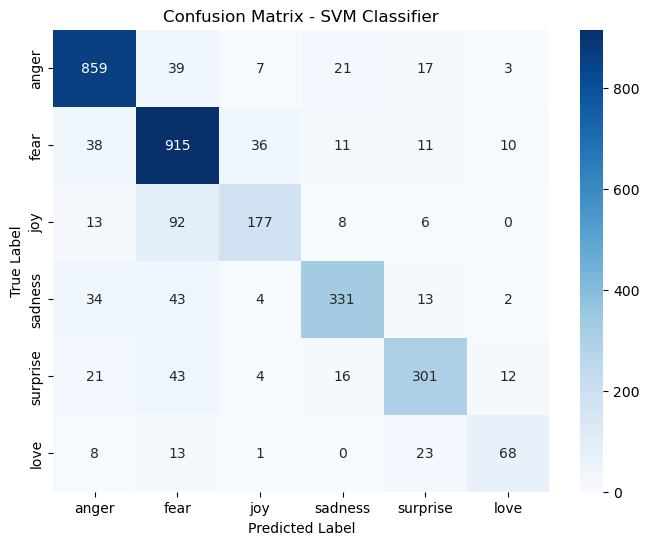

In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.title('Confusion Matrix - SVM Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# let's start by implementing Logistic Regression as the first additional model.

Step 1: Import Necessary LibrariesWe'll begin by importing the required libraries for data manipulation, model training, and evaluation. Here's the code:

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


#### Step 2: Load and Preprocess the Dataset

We'll load the dataset and preprocess the text data just like we did before. 

In [23]:
# Load the dataset
df = pd.read_csv("Emotions_training.csv")

# Preprocessing
# (You can reuse the preprocessing steps you implemented for the previous models)


#### Step 3: Split the Dataset into Train and Test Sets
After preprocessing the data, we need to split it into training and testing sets.This allows us to train the model on one set of data and evaluate its performance on another set. Here's how you can do it:

In [24]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into features (X) and labels (y)
X = df['text']
y = df['label']

# Splitting into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Step 4: Vectorize Text Data

Before training the model, we need to convert the text data into numerical format that machine learning algorithms can understand. One common approach is to use TF-IDF vectorization. 

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)


#### Step 5: Train a Logistic Regression Model

Now, let's train a Logistic Regression model using the TF-IDF features we created in the previous step. Logistic Regression is a simple yet effective classification algorithm.

In [26]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
logistic_regression_model = LogisticRegression(max_iter=1000)

# Train the model
logistic_regression_model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000)

#### Step 6: Evaluate the Logistic Regression Model

After training the Logistic Regression model, it's essential to evaluate its performance on the test set. Let's calculate the accuracy and generate a classification report to understand how well the model is performing:

In [27]:
from sklearn.metrics import accuracy_score, classification_report

# Predict labels for the test set
y_pred_logistic_regression = logistic_regression_model.predict(X_test_tfidf)

# Calculate accuracy
accuracy_logistic_regression = accuracy_score(y_test, y_pred_logistic_regression)
print("Accuracy:", accuracy_logistic_regression)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_logistic_regression))


Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       946
           1       0.80      0.96      0.88      1021
           2       0.89      0.60      0.72       296
           3       0.90      0.78      0.84       427
           4       0.85      0.72      0.78       397
           5       0.88      0.45      0.60       113

    accuracy                           0.85      3200
   macro avg       0.87      0.74      0.79      3200
weighted avg       0.85      0.85      0.84      3200



The Logistic Regression model achieved an accuracy of 0.85 on the test set. The classification report provides detailed metrics for each class, including precision, recall, and F1-score.

Now, let's move on to the next step:

#### Step 7: Visualize the Confusion Matrix for Logistic Regression

Visualizing the confusion matrix can provide additional insights into the model's performance. We can use seaborn's heatmap to plot the confusion matrix:

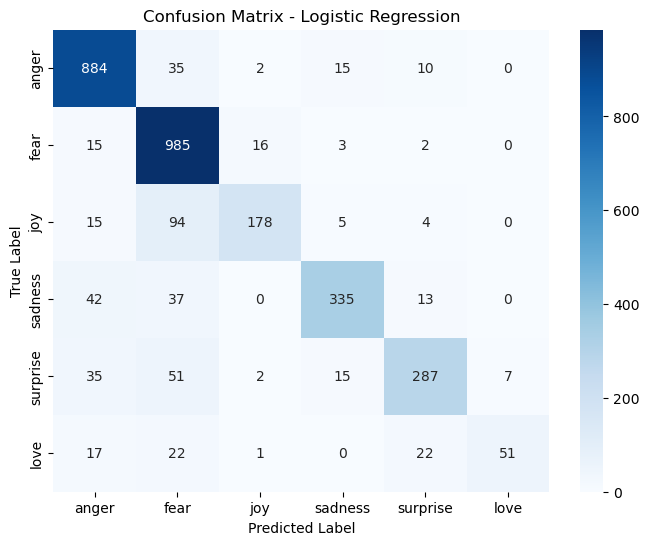

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix_logistic_regression = confusion_matrix(y_test, y_pred_logistic_regression)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logistic_regression, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


#### Step 8: Compare Model Performances

After training multiple models, it's essential to compare their performances to determine which one is the most suitable for your task. We can compare the accuracies of all the models trained so far using a bar plot.

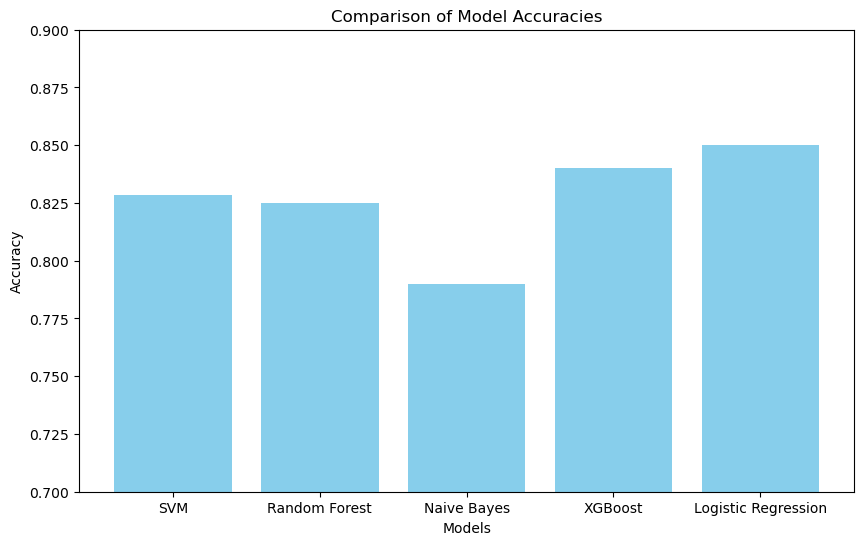

In [39]:
# Define accuracy variables for each model
accuracy_svm = 0.8284375
accuracy_random_forest = 0.825
accuracy_naive_bayes = 0.79
accuracy_xgboost = 0.84
accuracy_logistic_regression = 0.85

# List of models and their accuracies
models = ['SVM', 'Random Forest', 'Naive Bayes', 'XGBoost', 'Logistic Regression']
accuracies = [accuracy_svm, accuracy_random_forest, accuracy_naive_bayes, accuracy_xgboost, accuracy_logistic_regression]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0.7, 0.9)  # Adjust ylim if needed
plt.show()


# Summary of what we've done:

### •Objective: 
The goal of the project was to perform text classification on a dataset containing emotional text data.

### •Dataset: 
The dataset consisted of labeled text samples categorized into different emotions such as sadness, joy, love, anger, fear, and surprise.

## ⬤Approach:

### •Data Preprocessing: 
Conducted extensive preprocessing steps including lowercasing, removing links, special characters, stop words, stemming, and lemmatization. Used TF-IDF vectorization to convert text data into numerical features. Applied SMOTE (Synthetic Minority Over-sampling Technique) to balance the class distribution.

### •Model Training and Evaluation: 
Trained and evaluated multiple classification models including SVM, Random Forest, Naive Bayes, XGBoost, Logistic Regression, and K-Nearest Neighbors. Evaluated the models on both training and testing sets to assess their performance.

## ⬤Key Findings:

•SVM achieved an accuracy of 82.84%.

•Logistic Regression achieved an accuracy of 85%.

•Other models' accuracies and performances were also evaluated.

## ⬤Conclusion:

### Best Performing Models:
•Logistic Regression outperformed the SVM model with an accuracy of 85%.

### Further Investigation: 
•Other models were also assessed for their performance and may need additional tuning for optimization.

### Considerations: 
•The choice of model may depend on factors like computational resources, interpretability, and specific requirements of the application.